In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(256, 256),
    batch_size=32,
)

Found 7018 files belonging to 2 classes.


In [8]:
class_names = dataset.class_names
print(class_names)

['Cherry_Powdery_mildew', 'Cherry__healthy']


In [9]:
len(dataset)

220

In [10]:
# 0,1,2,3...9 classes (10 classes)
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    print(image_batch[0].shape)

(32, 256, 256, 3)
[0 0 1 1 0 0 1 1 1 0 1 1 0 0 1 0 0 1 1 0 0 1 0 0 0 1 1 1 0 1 0 1]
(256, 256, 3)


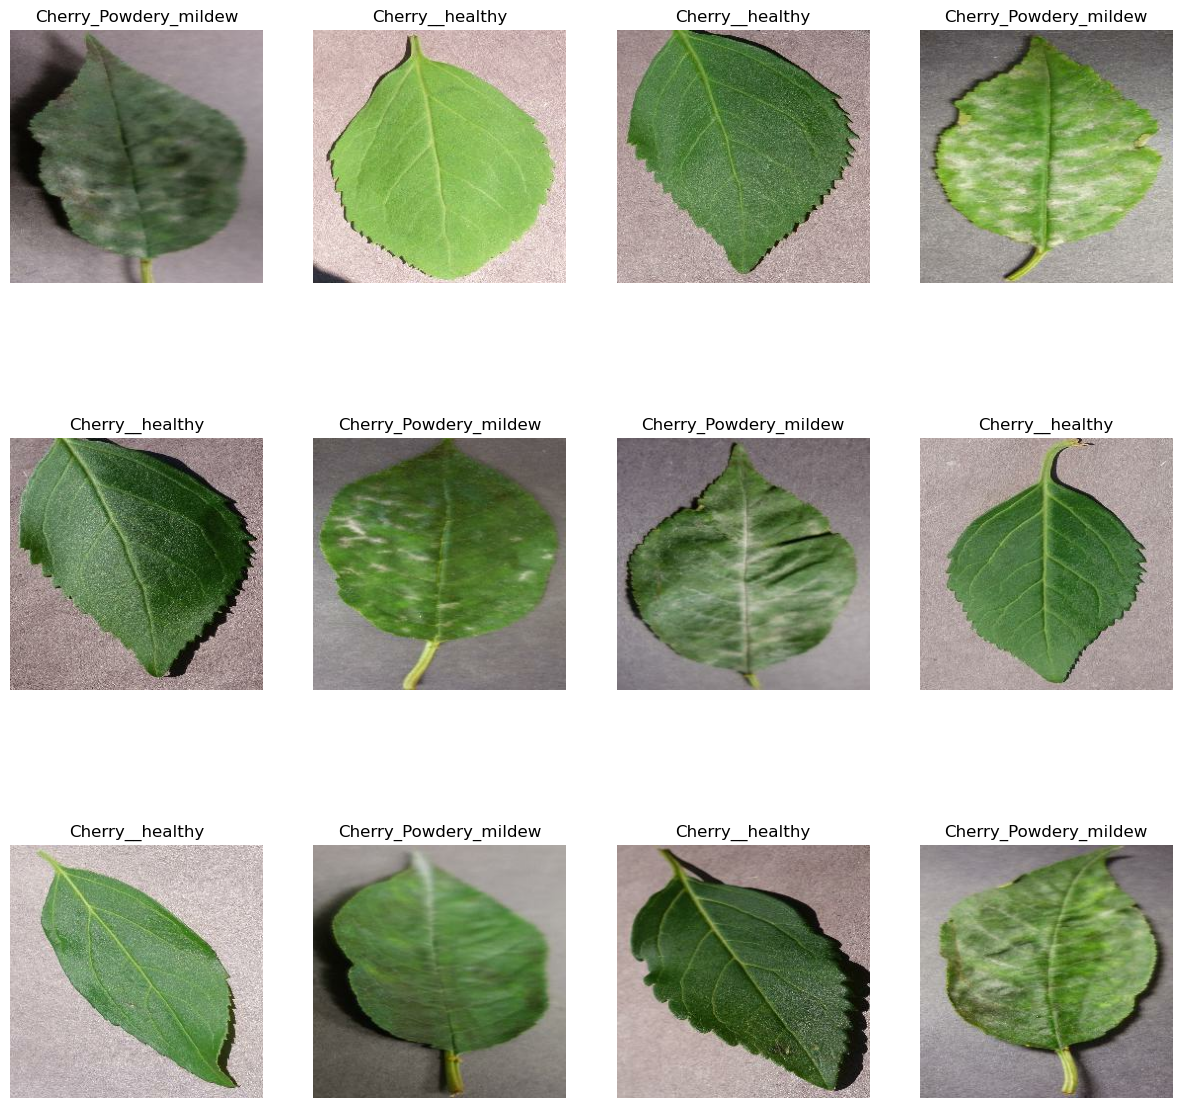

In [12]:
#visualize image
plt.figure(figsize=(15,15)) #to fix images size
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax= plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [10]:
#80% ==> training 
#20% ==> 10% validation, 10% test

In [14]:
train_size = 0.8
len(dataset)*train_size

176.0

In [15]:
train_ds = dataset.take(176)
len(train_ds)

176

In [16]:
test_ds = dataset.skip(176)
len(test_ds)

44

In [17]:
val_ds = test_ds.take(5)
len(val_ds)

5

In [18]:
test_ds = test_ds.skip(5)
len(test_ds)

39

In [19]:
def dataset_partition(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size = 10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [20]:
train_ds, val_ds, test_ds = dataset_partition(dataset)

In [21]:
print(len(train_ds),
len(val_ds),
len(test_ds))

176 22 22


In [22]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [23]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(256, 256),
    tf.keras.layers.Rescaling(1.0/255)
])

In [24]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [25]:
input_shape = (32, 256, 256, 3)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='softmax')
])
model.build(input_shape=input_shape)

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [27]:
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

In [28]:
history = model.fit(train_ds, 
          validation_data=val_ds, 
          epochs=50,
          batch_size=32,
          verbose=1)

Epoch 1/50


176/176 [==============================] - 29s 95ms/step - loss: 0.1677 - accuracy: 0.9248 - val_loss: 0.0396 - val_accuracy: 0.9901
Epoch 2/50
176/176 [==============================] - 14s 78ms/step - loss: 0.0370 - accuracy: 0.9891 - val_loss: 0.0321 - val_accuracy: 0.9872
Epoch 3/50
176/176 [==============================] - 13s 76ms/step - loss: 0.0258 - accuracy: 0.9902 - val_loss: 6.1384e-04 - val_accuracy: 1.0000
Epoch 4/50
176/176 [==============================] - 13s 77ms/step - loss: 0.0376 - accuracy: 0.9872 - val_loss: 0.0223 - val_accuracy: 0.9943
Epoch 5/50
176/176 [==============================] - 13s 77ms/step - loss: 0.0169 - accuracy: 0.9948 - val_loss: 0.0040 - val_accuracy: 0.9986
Epoch 6/50
176/176 [==============================] - 14s 77ms/step - loss: 0.0126 - accuracy: 0.9979 - val_loss: 0.0283 - val_accuracy: 0.9943
Epoch 7/50
176/176 [==============================] - 14s 78ms/step - loss: 0.0167 - accuracy: 0.9963 - val_loss: 0.0036 - val_accuracy: 0.9986

In [29]:
scores = model.evaluate(test_ds)

22/22 [==============================] - 3s 32ms/step - loss: 0.0786 - accuracy: 0.9830


In [30]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 176}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
history.history['accuracy']

[0.9247772097587585,
 0.9891265630722046,
 0.9901960492134094,
 0.9871657490730286,
 0.9948306679725647,
 0.9978609681129456,
 0.9962567090988159,
 0.9998217225074768,
 0.9998217225074768,
 0.9998217225074768,
 0.9998217225074768,
 0.9991087317466736,
 0.9948306679725647,
 0.9937611222267151,
 0.997504472732544,
 0.9976826906204224,
 0.9998217225074768,
 0.9996435046195984,
 0.9935829043388367,
 0.9989304542541504,
 0.9998217225074768,
 0.9998217225074768,
 0.9998217225074768,
 0.9976826906204224,
 0.9982174634933472,
 0.9985739588737488,
 0.9957219362258911,
 0.9998217225074768,
 0.9998217225074768,
 0.9991087317466736,
 0.9948306679725647,
 0.9994652271270752,
 1.0,
 0.9998217225074768,
 0.9946523904800415,
 0.9978609681129456,
 0.9996435046195984,
 0.9998217225074768,
 0.9998217225074768,
 0.9962567090988159,
 0.9992870092391968,
 0.9996435046195984,
 0.9998217225074768,
 0.9973261952400208,
 0.9991087317466736,
 0.9994652271270752,
 1.0,
 1.0,
 1.0,
 0.9998217225074768]

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

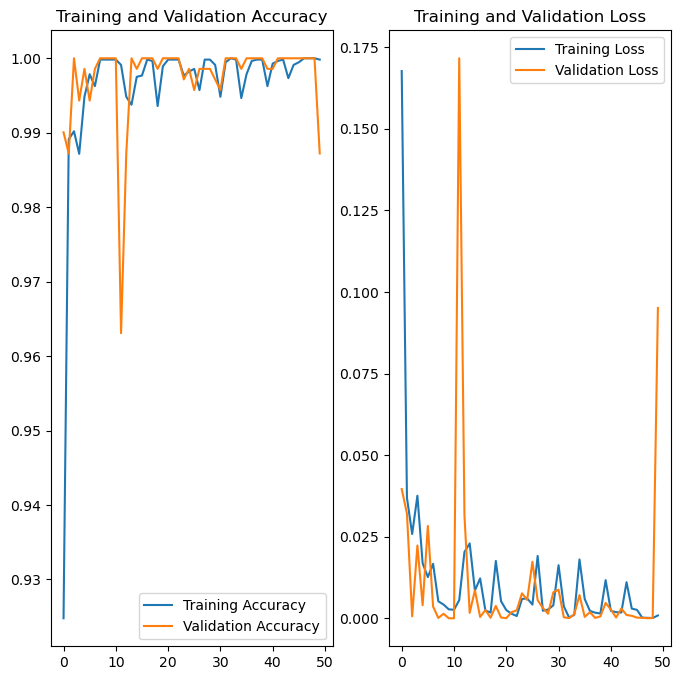

In [34]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

First image to predict
Actual lable:  Cherry_Powdery_mildew
1/1 [==============================] - 0s 16ms/step
Predicted lable:  Cherry_Powdery_mildew


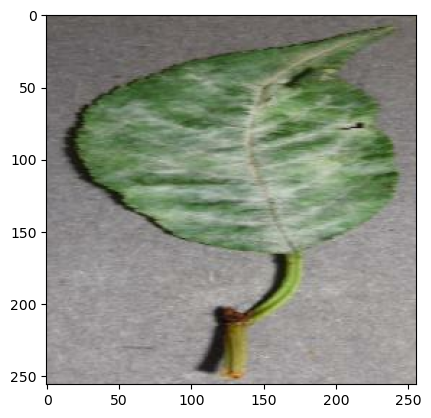

In [42]:
import numpy as np
for image_batch, label_batch in test_ds.take(1):
    first_image = (image_batch[0].numpy().astype("uint8"))
    first_lable = label_batch[0].numpy()

    print("First image to predict")

    plt.imshow(first_image)
    print("Actual lable: ", class_names[first_lable])
    #print(class_names[first_lable])

    batch_prediction = model.predict(image_batch)
    print("Predicted lable: ", class_names[np.argmax(batch_prediction[0])])

In [43]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 15ms/step


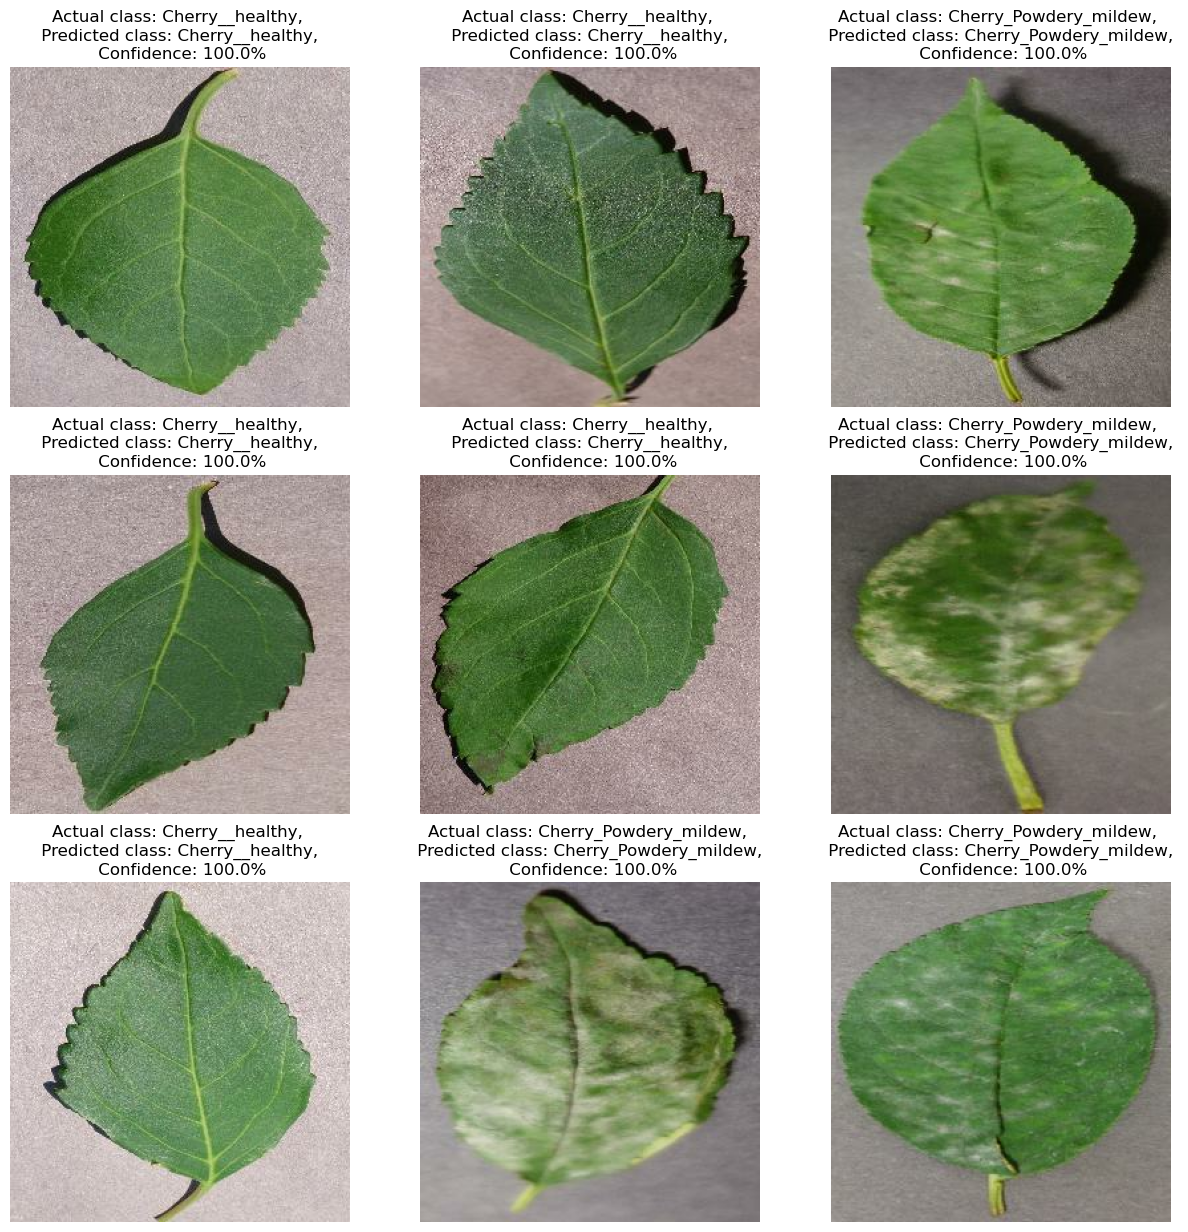

In [45]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]


        plt.title(f"Actual class: {actual_class}, \n Predicted class: {predicted_class}, \n Confidence: {confidence}%")
        plt.axis("off")

In [46]:
model_version = "Cherry_Training_v1"
model.save(f"../Models/{model_version}")



INFO:tensorflow:Assets written to: ../Models/Cherry_Training_v1\assets


INFO:tensorflow:Assets written to: ../Models/Cherry_Training_v1\assets
